In [1]:
! pip install mplhep > /dev/null
! pip install zfit > /dev/null

In [2]:
# Following https://stackoverflow.com/a/64604031
# Importing python libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys
from pathlib import Path
from matplotlib._api import check_in_list
import pickle
import os
import tensorflow as tf

from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[1] / "py")

if module_path not in sys.path:
    sys.path.append(module_path)

2024-01-29 17:46:00.022047: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 17:46:00.256908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 17:46:00.259271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 17:46:01.438165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import plot_tools
import zfit
import customPDFs
import SLSQPv2 as SLSQP_zfit

/home/carlos/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [4]:
from math import pi
from numpy import cos, sin

In [5]:
## Creating the Zfit configuration for the PDF

In [6]:
## Observables

cosThetaK = zfit.Space('cosThetaK', [-1,1])
cosThetaL = zfit.Space('cosThetaL', [-1,1])
phi = zfit.Space('phi', [0, pi])

# Defining the ranges of the variables of the observable space

combined_obs = cosThetaK * cosThetaL * phi

In [7]:
## Parameters

AFB = zfit.Parameter('AFB', 0)
FL = zfit.Parameter('FH', 0) # Changing the parameters just outside the allowed region
S39 = zfit.Parameter('S39', 0)

In [8]:
version =  zfit.__version__.split('.')
if int(version[1])>=5:
    from zfit import z
else:
    from zfit import ztf as z

class decayWidth(zfit.pdf.BasePDF):
    '''
    Decay B^0 -> K^{*0} \mu^+ \mu^-
    Funciona directamente con el parámetro de phi
    '''
    _PARAMS = ['FL', 'AFB', 'S39']

    def __init__(self, FL, AFB, S39, obs, name="angular_dist" ):
        # se debe definir los parametros a pasar a la pdf
        params = {
              'FL': FL,
              'AFB': AFB,
              'S39': S39}
        super().__init__(obs, params, name=name )#FL=FL, AFB=AFB, S3=S3, S9=S9) # params


    def _unnormalized_pdf(self, x):
        cosThetaK, cosThetaL, phi = z.unstack_x(x)

        #cos2phi = tf.math.cos(2*phi)

        FL = self.params['FL']
        AFB = self.params['AFB']
        S3 = self.params['S39']

        cosK2 = cosThetaK*cosThetaK
        cosL2 = cosThetaL*cosThetaL

        pdf = (3/4)*(1-FL)*(1-cosK2)
        pdf += FL*cosK2
        pdf += (1/4)*(1-FL)*(1-cosK2)*(2*cosL2-1)
        pdf += - FL*cosK2*(2*cosL2-1)
        pdf += S39*(1-cosK2)*(1-cosL2)*tf.math.cos(2*phi) 
        pdf += (4/3)*AFB*(1-cosK2)*cosL2
        pdf = pdf*9/(16*pi)
        return pdf

In [9]:
decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit

In [10]:
# Mesh to plot the whole PDF

cosThetaK_np = np.linspace(-1, 1, 10)
#x_np = np.zeros(100)
cosThetaL_np = np.linspace(-1, 1, 10)
#y_np = np.zeros(100)
phi_np = np.linspace(0, pi/2, 10)
#phi_np = np.ones(100) * pi/4

complete_space_list = []
for i in cosThetaK_np:
    for j in cosThetaL_np:
        for k in phi_np:
            item = (i,j,k)
            complete_space_list.append(item)
    #print(len(complete_space_list))

complete_space_np = np.array(complete_space_list).reshape(len(cosThetaK_np),len(cosThetaL_np),len(phi_np), 3)

# data_mesh_lst = list(zip(cosThetaK_np, cosThetaL_np, phi_np))

# data_mesh = np.array(data_mesh_lst)# This is not quite a mesh, but we have an ordered set

In [69]:
complete_space_np

array([[[[-1.        , -1.        ,  0.        ],
         [-1.        , -1.        ,  0.17453293],
         [-1.        , -1.        ,  0.34906585],
         ...,
         [-1.        , -1.        ,  1.22173048],
         [-1.        , -1.        ,  1.3962634 ],
         [-1.        , -1.        ,  1.57079633]],

        [[-1.        , -0.77777778,  0.        ],
         [-1.        , -0.77777778,  0.17453293],
         [-1.        , -0.77777778,  0.34906585],
         ...,
         [-1.        , -0.77777778,  1.22173048],
         [-1.        , -0.77777778,  1.3962634 ],
         [-1.        , -0.77777778,  1.57079633]],

        [[-1.        , -0.55555556,  0.        ],
         [-1.        , -0.55555556,  0.17453293],
         [-1.        , -0.55555556,  0.34906585],
         ...,
         [-1.        , -0.55555556,  1.22173048],
         [-1.        , -0.55555556,  1.3962634 ],
         [-1.        , -0.55555556,  1.57079633]],

        ...,

        [[-1.        ,  0.55555556,  0

In [11]:
dr_pdf = decay_rate.pdf(complete_space_np)

Estimated integral error ( 3.3813909976622394e-06 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).


In [12]:
type(dr_pdf)

tensorflow.python.framework.ops.EagerTensor

In [13]:
def evaluate_validity_pdf(pdf):
    valid_pdf = True
    complete_space_list = []
    for i, _i in enumerate(cosThetaK_np):
        for j, _j in enumerate(cosThetaL_np):
            for k, _k in enumerate(phi_np):
                if pdf[i,j,k].numpy() < 0:
                    valid_pdf = False
                    break
            if not valid_pdf:
                break
        if not valid_pdf:
            break
    #print(valid_pdf)
    return valid_pdf

In [14]:
evaluate_validity_pdf(dr_pdf)

True

In [33]:
AFB_np = np.linspace(-3, 3, 20)
FL_np = np.linspace(-3, 3, 20)
S39_np = np.linspace(-3, 3, 20)

In [19]:
valid_list = []
S39.set_value(0)
for i, afb_ in enumerate(AFB_np):
    AFB.set_value(afb_)
    for j, fl_ in enumerate(FL_np):
        FL.set_value(fl_)
        decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit
        dr_pdf = decay_rate.pdf(complete_space_np)
        valid_list.append(evaluate_validity_pdf(dr_pdf))

Estimated integral error ( 2.6158544581454929e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).
Estimated integral error ( 2.322821722576172e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase

In [20]:
valid_np = np.array(valid_list).reshape(len(AFB_np), len(FL_np))
valid_np

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [Fa

In [21]:
# Save the numpy arrays with values and plots on the computer
# np.save('np_arrays/afb_20_fl_20_s39-0.npy', valid_np)


In [34]:
#np.save('np_arrays/afb_range.npy', AFB_np)
#np.save('np_arrays/fl_range.npy', FL_np)
#np.save('np_arrays/s39_range.npy', S39_np)

In [23]:
valid_points_FL = []
valid_points_AFB = []

for i, vnp_afb in enumerate(valid_np):
    for j, vnp_fl in enumerate(vnp_afb):
        if vnp_fl==True:
            valid_points_FL.append(FL_np[j])
            valid_points_AFB.append(AFB_np[i])

In [24]:
valid_points_FL

[0.1578947368421053,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 1.1052631578947363,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 1.1052631578947363,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 1.1052631578947363,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 1.1052631578947363,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 1.1052631578947363]

In [26]:
valid_points_AFB

[-0.47368421052631593,
 -0.1578947368421053,
 -0.1578947368421053,
 -0.1578947368421053,
 0.1578947368421053,
 0.1578947368421053,
 0.1578947368421053,
 0.4736842105263155,
 0.4736842105263155,
 0.4736842105263155,
 0.7894736842105261,
 0.7894736842105261,
 0.7894736842105261,
 1.1052631578947363,
 1.1052631578947363,
 1.1052631578947363,
 1.421052631578947,
 1.421052631578947,
 1.421052631578947,
 1.7368421052631575,
 1.7368421052631575,
 1.7368421052631575,
 1.7368421052631575,
 2.052631578947368,
 2.052631578947368,
 2.052631578947368,
 2.052631578947368,
 2.3684210526315788,
 2.3684210526315788,
 2.3684210526315788,
 2.3684210526315788,
 2.6842105263157894,
 2.6842105263157894,
 2.6842105263157894,
 2.6842105263157894,
 3.0,
 3.0,
 3.0,
 3.0]

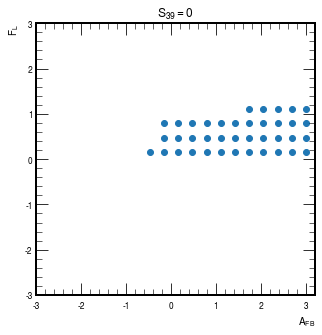

In [54]:
plt.figure(figsize=(5,5))
plt.scatter(valid_points_AFB, valid_points_FL)
plt.axis((-3, 3.2, -3, 3))
plt.xlabel('$A_{FB}$')
plt.ylabel('$F_L$')
plt.title('$S_{39}=0$')
plt.savefig('afb_20_fl_20_s39-0.png')
plt.show()


In [35]:
FL.set_value(2)
AFB.set_value(2)
S39.set_value(0)
decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit
dr_pdf = decay_rate.pdf(complete_space_np)

Estimated integral error ( 1.3615578318037562e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).


In [37]:
dr_pdf.shape

TensorShape([10, 10, 10])

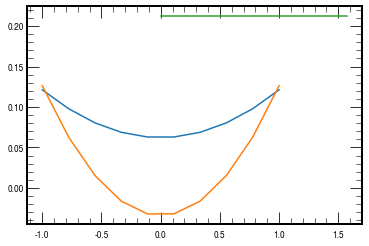

In [48]:
 
plt.plot(cosThetaK_np, dr_pdf[:, 1, 0])
plt.plot(cosThetaL_np, dr_pdf[4, :, 1])
plt.plot(phi_np,  dr_pdf[0, 2, :])

In [61]:
def calculating_valid_pdfs(s39_val):
    path = f'np_arrays/afb_20_fl_20_s39-{s39_val}.npy'
    if not os.path.isfile(path):
        valid_list = []
        S39.set_value(s39_val)
        for i, afb_ in enumerate(AFB_np):
            AFB.set_value(afb_)
            for j, fl_ in enumerate(FL_np):
                FL.set_value(fl_)
                decay_rate = decayWidth(FL, AFB, S39, combined_obs) # Crea una PDF del Base PDF de zfit
                dr_pdf = decay_rate.pdf(complete_space_np)
                valid_list.append(evaluate_validity_pdf(dr_pdf))
        valid_np = np.array(valid_list).reshape(len(AFB_np), len(FL_np))
        np.save(f'np_arrays/afb_20_fl_20_s39-{s39_val}.npy', valid_np)
    else: 
        valid_np = np.load(path)

    valid_points_FL = []
    valid_points_AFB = []
    
    for i, vnp_afb in enumerate(valid_np):
        for j, vnp_fl in enumerate(vnp_afb):
            if vnp_fl==True:
                valid_points_FL.append(FL_np[j])
                valid_points_AFB.append(AFB_np[i])
    # Plotting
    plt.figure(figsize=(5,5))
    plt.scatter(valid_points_AFB, valid_points_FL)
    plt.axis((-3, 3.2, -3, 3))
    plt.xlabel('$A_{FB}$')
    plt.ylabel('$F_L$')
    plt.title('$S_{39}='+str(s39_val)+'$')
    plt.savefig(f'afb_20_fl_20_s39-{s39_val}.png')
    plt.show()

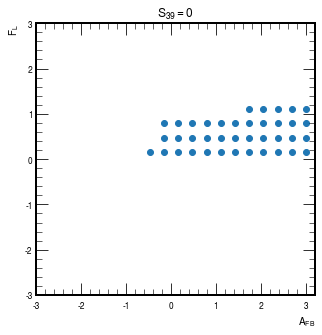

In [58]:
calculating_valid_pdfs(0)

Estimated integral error ( 3.1132569233273723e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increase the 'max_draws' (or adjust 'tol'). If partial integration is chosen, this can lead to large memory consumption.This is a new warning checking the integral accuracy. It may warns too often as it is Work In Progress. If you have any observation on it, please tell us about it: https://github.com/zfit/zfit/issues/new/chooseTo suppress this warning, use zfit.settings.set_verbosity(-1).
Estimated integral error ( 2.8714409345471117e-05 ) larger than tolerance ( 3e-06 ), which is maybe not enough (but maybe it's also fine). You can (best solution) implement an anatytical integral (see examples in repo) or manually set a higher number on the PDF with 'update_integration_options' and increas

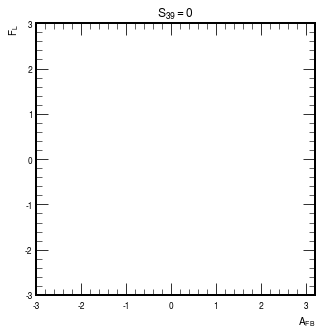

In [59]:
calculating_valid_pdfs(S39_np[0])

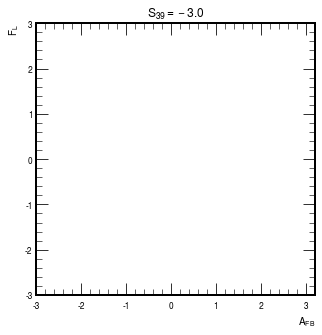

In [62]:
calculating_valid_pdfs(S39_np[0])

In [66]:
S39_np

array([-3.        , -2.68421053, -2.36842105, -2.05263158, -1.73684211,
       -1.42105263, -1.10526316, -0.78947368, -0.47368421, -0.15789474,
        0.15789474,  0.47368421,  0.78947368,  1.10526316,  1.42105263,
        1.73684211,  2.05263158,  2.36842105,  2.68421053,  3.        ])

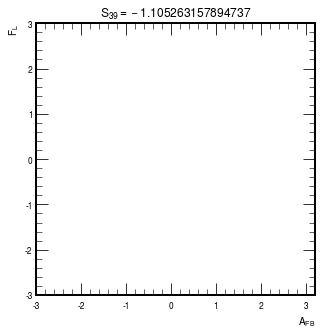

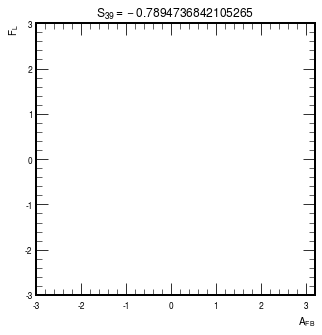

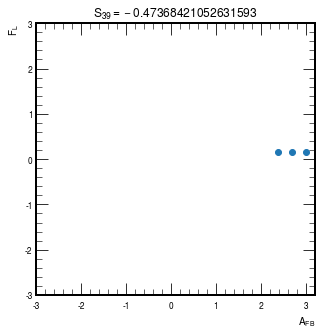

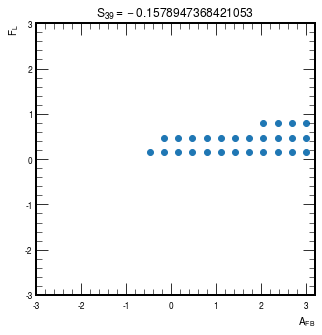

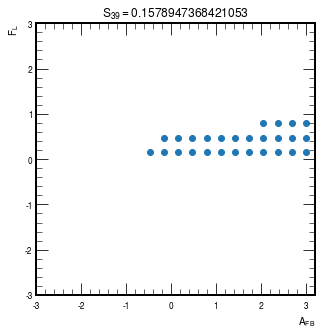

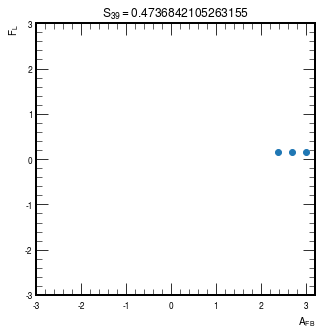

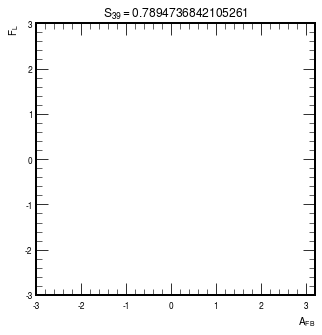

--- 1.9411425590515137 seconds ---


In [68]:
start_time = time.time()
for s39 in S39_np[6:13]:
    calculating_valid_pdfs(s39)
#calculating_valid_pdfs(S39_np[2])
print("--- %s seconds ---" % (time.time() - start_time))

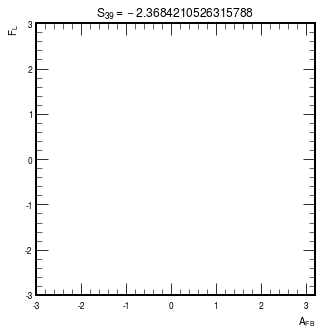

In [65]:
calculating_valid_pdfs(S39_np[2])